In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np
import os

In [2]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [3]:
road_density = pd.read_excel('../New_Data/road_density.xlsx')  
road_density = road_density.rename(columns={"longitude": "lon", "latitude": "lat"})

In [4]:
# example to use geodesic()
from geopy.distance import geodesic

# Define the coordinates
coords_1 = (40.452058, -124.374975)
coords_2 = (40.41039, -124.374975)

# Calculate the distance
distance = geodesic(coords_1, coords_2).km

# Print the distance
print(f"Distance: {distance} km")

Distance: 4.626936837923472 km


In [5]:
lon_lat_combinations = pd.read_parquet('../Clean_Data/lon_lat_pair_weather_match_veg.parquet')

In [6]:
lon_lat_combinations.dtypes

lon         float64
lat         float64
type        float32
distance    float64
dtype: object

In [7]:
road_density.dtypes

lat                    float64
lon                    float64
road_density_km_km2    float64
road_length_km         float64
grid_area_km2          float64
dtype: object

In [6]:
from scipy.spatial import cKDTree

# Create a KDTree
tree = cKDTree(road_density[['lat', 'lon']].values)

# Query the nearest neighbors for each point in lon_lat_combinations
approx_distances, indices = tree.query(lon_lat_combinations[['lat', 'lon']].values, k=1)

In [9]:
approx_distances.min(), approx_distances.max()

(1.4210854715202004e-14, 6.896029083008445e-07)

In [7]:
# Calculate the exact geodesic distances
exact_distances = []
#nearest_lats = []
#nearest_lons = []
for i, idx in enumerate(indices):
    coords_1 = (lon_lat_combinations.iloc[i]['lat'], lon_lat_combinations.iloc[i]['lon'])
    coords_2 = (road_density.iloc[idx]['lat'], road_density.iloc[idx]['lon'])
    distance = geodesic(coords_1, coords_2).km
    exact_distances.append(distance)

# Convert exact_distances to a numpy array
exact_distances = np.array(exact_distances)

In [11]:
exact_distances.min(), exact_distances.max()

(1.1776873181191363e-12, 7.281315359733987e-05)

In [8]:
lon_lat_combinations['road_density_km_km2'] = road_density.iloc[indices]['road_density_km_km2'].values

In [9]:
# drop type and distance columns
lon_lat_combinations = lon_lat_combinations.drop(columns=['type', 'distance'])

In [15]:
lon_lat_combinations.dtypes

lon                    float64
lat                    float64
road_density_km_km2    float64
dtype: object

In [10]:
lon_lat_combinations.head()

,lon,lat,road_density_km_km2
2197,-124.391667,40.441667,2.269030
2198,-124.391667,40.400000,2.267646
2434,-124.350000,40.566667,0.000000
2435,-124.350000,40.525000,0.000000
2436,-124.350000,40.483333,2.270416


In [11]:
lon_lat_combinations.shape

(17703, 3)

Text(0.5, 1.0, 'Distribution of Road Density in lon_lat_combinations')

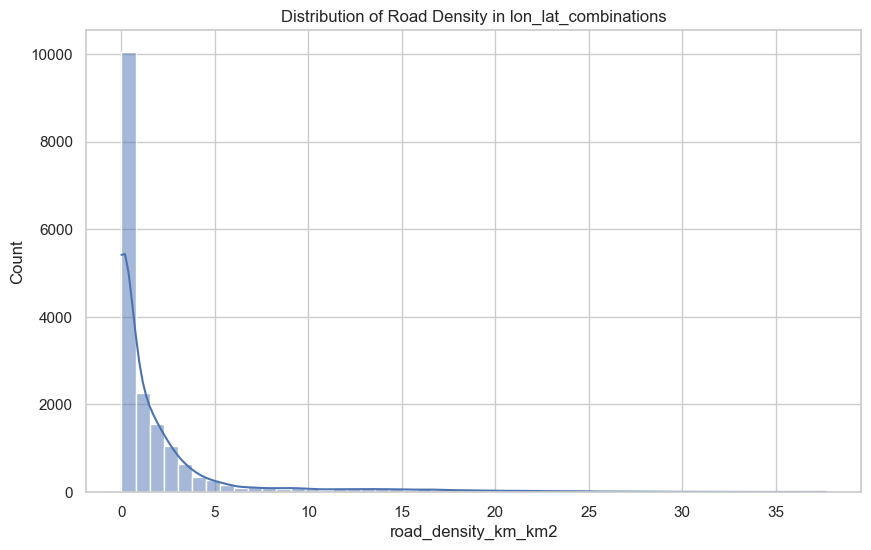

In [ ]:
# plot the distribution of road_density_km_km2 in lon_lat_combinations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(lon_lat_combinations['road_density_km_km2'], bins=50, kde=True)
# plt.title('Distribution of Road Density in lon_lat_combinations')
# plt.xlabel('Road Density (km/km²)')
# plt.ylabel('Frequency')
# plt.xlim(0, 20)
# plt.ylim(0, 1000)
# plt.grid(True)
# plt.show()

In [12]:
lon_lat_combinations['road_density_km_km2'].min(), lon_lat_combinations['road_density_km_km2'].max()

(0.0, 37.69388206657994)

In [13]:
# add the log transformation of road_density_km_km2
lon_lat_combinations['road_density_km_km2_log'] = np.log(lon_lat_combinations['road_density_km_km2'] + 1)

<Axes: xlabel='road_density_km_km2_log', ylabel='Count'>

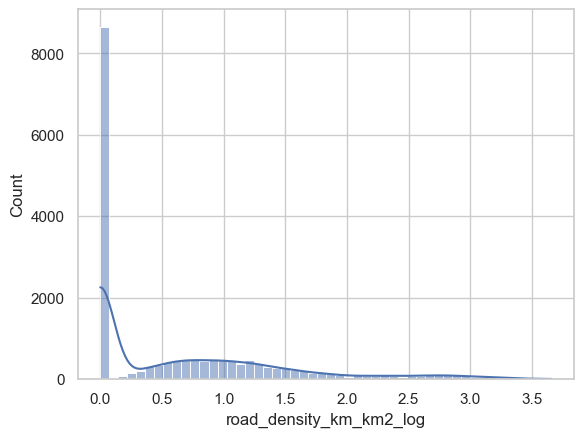

In [23]:
sns.histplot(lon_lat_combinations['road_density_km_km2_log'], bins=50, kde=True)

In [14]:
# write to parquet
lon_lat_combinations.to_parquet('../Clean_Data/road_density_match_weather_grid.parquet')

### Why we need to mapping again

In [10]:
veg_dat = pd.read_parquet('../Clean_Data/lon_lat_pair_weather_match_veg.parquet')

In [20]:
a1 = road_density[(road_density['latitude'] >= 40.44) & (road_density['latitude'] <= 40.442) & (road_density['longitude'] >= -124.4) & (road_density['longitude'] <= -124.39)]
a2 = veg_data.head(1)

In [21]:
a1

,latitude,longitude,road_density_km_km2,road_length_km,grid_area_km2
13941,40.441667,-124.391667,2.26903,37.112261,16.356001


In [22]:
a2

,longitude,latitude,type,distance
2197,-124.391667,40.441667,7.0,1.826642


In [26]:
a1['latitude'].values[0]

40.44166666666666

In [27]:
a2['latitude'].values[0]

40.44166666666667

In [25]:
# check if latitude in a2 is the same as latitude in a1: first row
a1['latitude'].values[0] == a2['latitude'].values[0]

False